### Defining the aoi

In [1]:
import pandas as pd
import numpy as np
import xarray as xa
from pathlib import Path
import src.data.ecostress_io as eio
import src.data.ecostress_stack as es
import src.data.era_stack_resample as esr
import rioxarray
import sys
import geopandas as gpd
import json
import dask
from dask.distributed import Client
import matplotlib.pyplot as plt

n_partitions = 8
root_path = Path("/mnt/ecostress/rhone-ecostress-data/")
bounds_tuple = (4, 42, 7, 47)
xmin, ymin, xmax, ymax = bounds_tuple  # hardcoding since concattenating 1000s of ecostress files with different overlaps hangs

### Subsetting global rivers dataset
This dataset needs to be examined more closely. some second order streams appear to be missed and I'm not sure if channels are digitized as river.

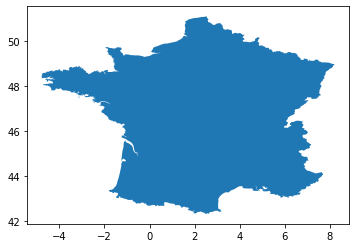

In [2]:
rivers_df = gpd.read_file(Path(root_path, "europe_rivers/eu_river.shp"))

rivers_df['R_ID'] = rivers_df['R_ID'].apply(int).apply(str)

france_rivers_df = rivers_df.cx[xmin:xmax, ymin:ymax]

aoi = es.filter_countries_for_france_aoi(root_path)

aoi.crs = france_rivers_df.crs # setting crs for aoi

### Processing ERA Land Reanalysis data, or reading it if it has been previously processed and saved

9km nominal resolution is downsampled to Ecostress resolution on a 4326 geographic grid spanning the bounding box defined above.

In [3]:
resampled_vpd_ds = esr.read_or_process(root_path, dataset_filename = "Daily_VPD_10am-3pm_Paris_Time_Resampled.nc")
resampled_vpd_da = resampled_vpd_ds["Daily_VPD_10am-3pm_Paris_Time_Resampled"]

Daily_VPD_10am-3pm_Paris_Time_Resampled  done reading


### making path lists to products

In [4]:
l3qa_path = Path(root_path, "ECO3ANCQA")
et_path = Path(root_path, "ECO3ETPTJPL")
esi_path = Path(root_path, "ECO4ESIPTJPL")
l2_path = Path(root_path, "ECO2")

tempdir_daily = Path("/home/ryan/work/tmp")
whole_tif_etdaily_paths, csv_et_paths, xml_et_paths = eio.separate_by_pattern(et_path, "*ETdaily*.tif")

tempdir_inst = Path("/home/ryan/work/tmp-inst")
whole_tif_etinst_paths, csv_etinst_paths, xml_etinst_paths = eio.separate_by_pattern(et_path, "*ETinst_*.tif")

tempdir_l3qa = Path("/mnt/tmp-l3qa")
whole_tif_l3qa_paths, csv_qa_paths, xml_qa_paths = eio.separate_by_pattern(l3qa_path)

tempdir_l2qa = Path("/mnt/tmp-l2qa")
whole_tif_l2qa_paths, csv_l2qa_paths, xml_l2qa_paths = eio.separate_by_pattern(l2_path, "*SDS-QC*.tif")

tempdir_l2cloud = Path("/mnt/tmp-l2cloud")
whole_tif_l2cloud_paths, csv_l2cloud_paths, xml_l2cloud_paths = eio.separate_by_pattern(l2_path, "*SDS_CloudMask*.tif")

In [9]:
from rasterio.enums import Resampling
etdaily_tseries = es.clip_resample_ecostress_product(whole_tif_etdaily_paths, bounds_tuple, filter_nan=True, tempdir=tempdir_daily, resampling_method=Resampling.bilinear)
etinst_tseries = es.clip_resample_ecostress_product(whole_tif_etinst_paths, bounds_tuple, filter_nan=True, tempdir=tempdir_inst, resampling_method=Resampling.bilinear)
l3qa_tseries = es.clip_resample_ecostress_product(whole_tif_l3qa_paths, bounds_tuple, filter_nan=True, tempdir=tempdir_l3qa, resampling_method=Resampling.bilinear)
l2qa_tseries = es.clip_resample_ecostress_product(whole_tif_l2qa_paths, bounds_tuple, filter_nan=True, tempdir=tempdir_l2qa, resampling_method=Resampling.nearest)
l2cloud_tseries = es.clip_resample_ecostress_product(whole_tif_l2cloud_paths, bounds_tuple, filter_nan=True, tempdir=tempdir_l2cloud, resampling_method=Resampling.nearest)

NameError: name 'france_rivers_df' is not defined

Need to merge ET arrays taken on same date together to reduce time coord duplicates that occur because of partial scene overlaps and large aoi. nanmean should replace nans with a true value, 2 or more true values with the mean for that day (should only happena t the overlaps, infrequently), and all nan slices with nan.

Below I'm working on joining vpd and et by time and removing duplicates

In [20]:
et_tseries = et_tseries.rename({'date':'time'})

et_tseries_ds = et_tseries.to_dataset().sel(band=1)

et_tseries_ds['time'] = et_tseries_ds['time'].values.astype('datetime64[D]')

duplicated_mask = pd.to_datetime(np.array(et_tseries_ds['time'])).duplicated(keep=False)

duplicate_dates = np.unique(et_tseries_ds.isel(time=duplicated_mask)['time'])

duplicated_da = et_tseries_ds.isel(time=duplicated_mask).sel()

In [21]:
duplicate_xarr_list = []
for duplicate in duplicate_dates:
    date = pd.to_datetime(duplicate).strftime("%Y-%m-%d")
    arr = et_tseries.sel(time=date)
    arr = arr.where(arr != -1e+13) 
    duplicate_mean = arr.mean(dim="time")
    duplicate_mean = duplicate_mean.assign_coords({'time': duplicate})
    duplicate_xarr_list.append(duplicate_mean)


In [22]:
mean_duplicate_xarr = xa.concat(duplicate_xarr_list, dim="time")

In [23]:
et_tseries_ds.attrs['units'] = "W/m^2"

In [24]:
et_tseries_ds

<xarray.Dataset>
Dimensions:                                                                                         (time: 104, x: 6558, y: 6101)
Coordinates:
    band                                                                                            int64 1
  * x                                                                                               (x) float64 7.957 ... 3.827
  * y                                                                                               (y) float64 43.35 ... 47.2
  * time                                                                                            (time) datetime64[ns] 2018-07-29 ... 2019-10-23
Data variables:
    ECO3ETPTJPL001_EVAPOTRANSPIRATION_PT_JPL_ETinst_doy2018233132423_aid0001-clipped-resampled.tif  (time, y, x) float32 dask.array<chunksize=(1, 6101, 6558), meta=np.ndarray>
Attributes:
    units:    W/m^2

In [25]:
et_tseries_ds_dups = et_tseries_ds.isel(time=duplicated_mask).rename({"ECO3ETPTJPL001_EVAPOTRANSPIRATION_PT_JPL_ETinst_doy2018233132423_aid0001-clipped-resampled.tif":"ECO3ETPTJPL"})

et_tseries_ds_no_dups = et_tseries_ds.isel(time=~duplicated_mask).rename({"ECO3ETPTJPL001_EVAPOTRANSPIRATION_PT_JPL_ETinst_doy2018233132423_aid0001-clipped-resampled.tif":"ECO3ETPTJPL"}) # gettign rid of duplicates in original et xarr

et_tseries_ds_dups=et_tseries_ds_dups.where(et_tseries_ds_dups["ECO3ETPTJPL"] != -1e+13) 

et_tseries_ds_no_dups=et_tseries_ds_no_dups.where(et_tseries_ds_no_dups["ECO3ETPTJPL"] != -1e+13) 

In [26]:
mean_duplicate_dataset = mean_duplicate_xarr.to_dataset().sel(band=1).rename({"ECO3ETPTJPL001_EVAPOTRANSPIRATION_PT_JPL_ETinst_doy2018233132423_aid0001-clipped-resampled.tif":"ECO3ETPTJPL"})

In [27]:
et_vpd_ds = xa.concat([et_tseries_ds_no_dups, mean_duplicate_dataset], dim="time").sortby("time")

Profiling why there are edge effects between ET Daily Scenes

In [28]:
duplicate_dates = [pd.to_datetime(date).strftime("%Y-%m-%d") for date in duplicate_dates]


In [29]:
resampled_data_arrays[0]['date'].dt.month.values

array(8)

In [30]:
for path in whole_tif_etdaily_paths:
    if "2018222" in str(path):
        print(path)

/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinst_doy2018222131552_aid0001.tif
/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinst_doy2018222131644_aid0001.tif
/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinst_doy2018222180613_aid0001.tif
/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinst_doy2018222180704_aid0001.tif


In [31]:
resampled_data_arrays_profile = []
for da in resampled_data_arrays:
    if str(da.date.dt.month.values) == "8" and str(da.date.dt.year.values) == "2018" and str(da.date.dt.day.values) == "10":
        resampled_data_arrays_profile.append(da.where(da!=-1e+13))

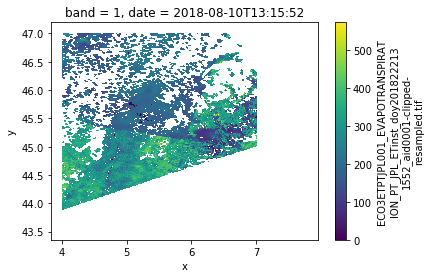

In [32]:
resampled_data_arrays_profile[0][0].plot.imshow()

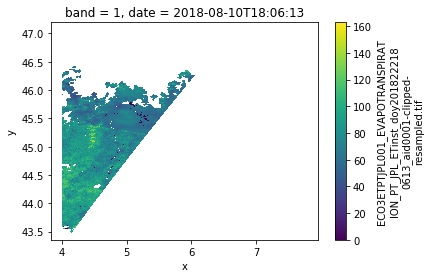

In [33]:
resampled_data_arrays_profile[1][0].plot.imshow()

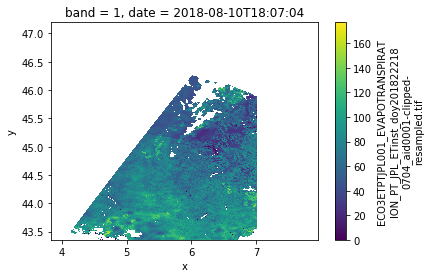

In [34]:
resampled_data_arrays_profile[-1][0].plot.imshow()

Instantaeous uncertainty

In [35]:
inst_uncertainty_paths = ["/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinstUncertainty_doy2018222131552_aid0001.tif",
"/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinstUncertainty_doy2018222180613_aid0001.tif",
"/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinstUncertainty_doy2018222180704_aid0001.tif"]

In [36]:
inst_uncertainty_paths = [Path(path) for path in inst_uncertainty_paths]

In [37]:
clipped_uncertainty_paths = eio.clip_and_save(inst_uncertainty_paths, bounds_tuple, filter_nan = True, outDir=Path('/home/ryan/work/'))

In [38]:
uncertainty_scenes = eio.read_scenes([Path(path) for path in clipped_uncertainty_paths])


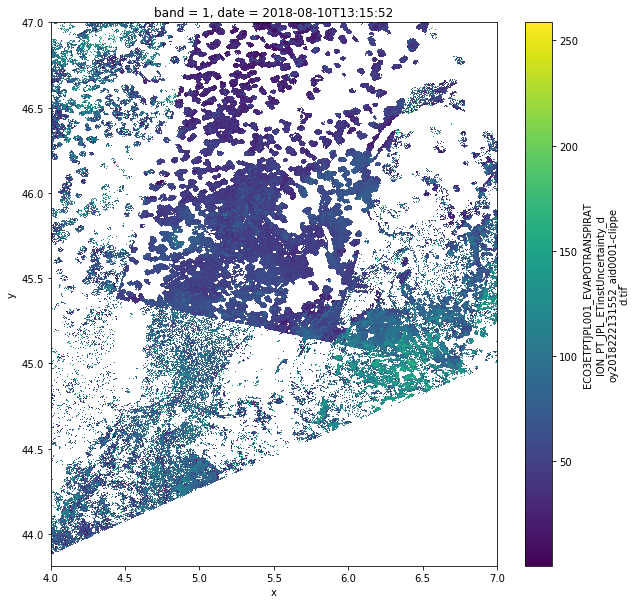

In [39]:
uncertainty_scenes[0][0].attrs['units'] = "W/m^2"
uncertainty_scenes[0][0].plot.imshow(figsize=(10,10))

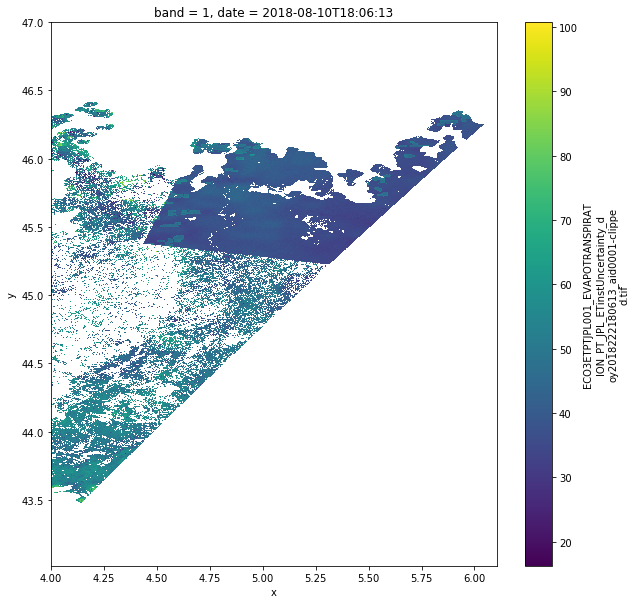

In [40]:
uncertainty_scenes[1][0].plot.imshow(figsize=(10,10))

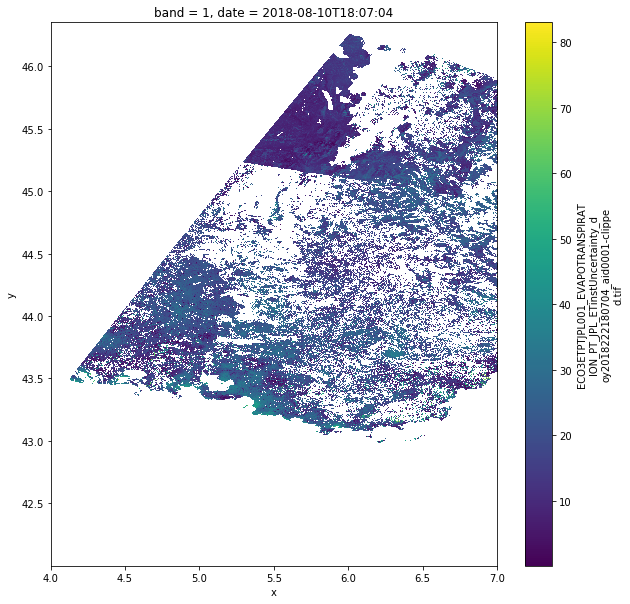

In [41]:
uncertainty_scenes[2][0].plot.imshow(figsize=(10,10))

Plotting histograms where scenes intersect

In [42]:
date_to_plot = duplicate_dates[1]
n_scenes = len(et_tseries_ds_dups.sel(time=date_to_plot)['time'])
data_to_plot = et_tseries_ds_dups["ECO3ETPTJPL"].sel(time=date_to_plot).drop("band")

In [43]:
valid_intersect_data = data_to_plot.where((data_to_plot[0] > 0) & (data_to_plot[1] > 0) & (data_to_plot[2] > 0))

/data/anaconda/envs/geo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/data/anaconda/envs/geo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/data/anaconda/envs/geo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


Text(0.5, 1.0, 'Instantaneous ET Disagreement between the intersection of 3 Ecostress scenes on August 10, 2018, France')

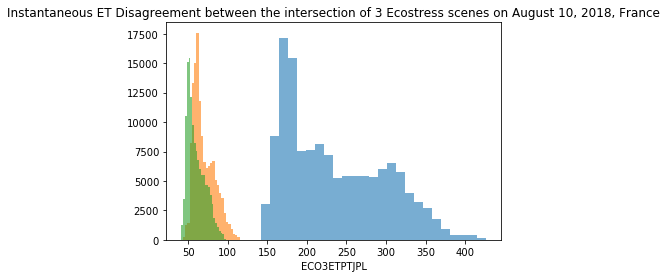

In [44]:
f, ax = plt.subplots(1)
xa.plot.hist(valid_intersect_data[0],ax=ax, alpha=.6, bins = 25)
xa.plot.hist(valid_intersect_data[1],ax=ax, alpha=.6, bins = 25)
xa.plot.hist(valid_intersect_data[2],ax=ax, alpha=.6, bins = 25)
plt.title("Instantaneous ET Disagreement between the intersection of 3 Ecostress scenes on August 10, 2018, France")

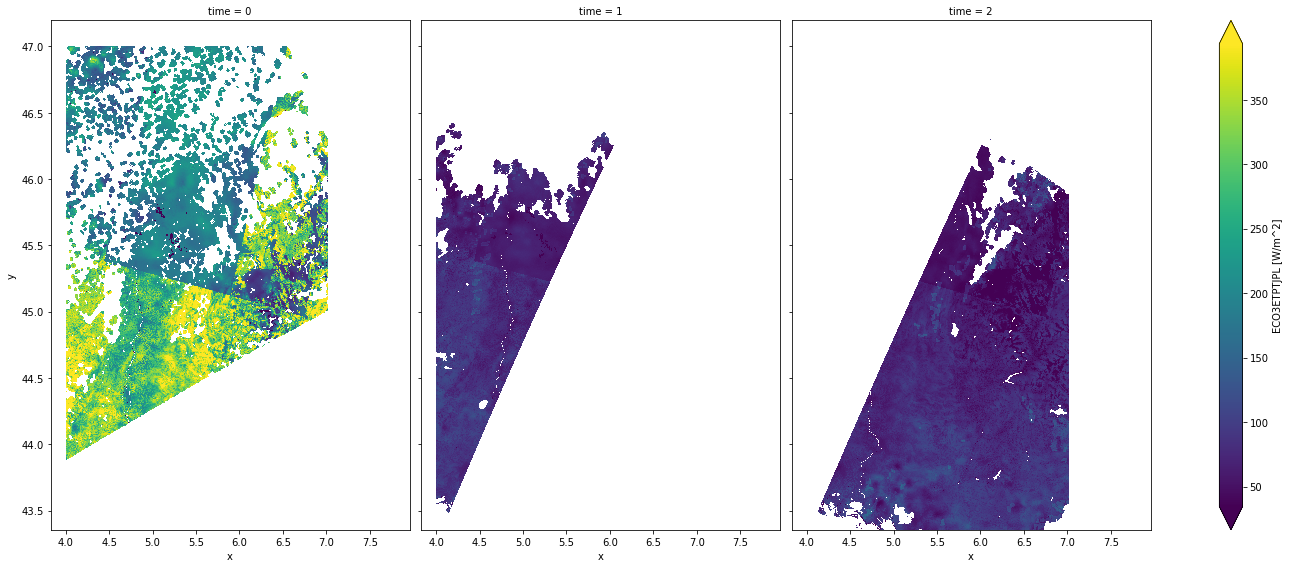

In [45]:
data_to_plot['time'] = [0, 1, 2]
data_to_plot.attrs['units'] = "W/m^2"
data_to_plot.plot.imshow(x='x', y='y', col='time', col_wrap=n_scenes, robust=True, figsize=(20,8))
# plt.title(f"{n_scenes} individual scenes for date {date_to_plot}", fontsize=20)

/data/anaconda/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, '3 scenes for date 2018-08-10, mean taken at overlaps')

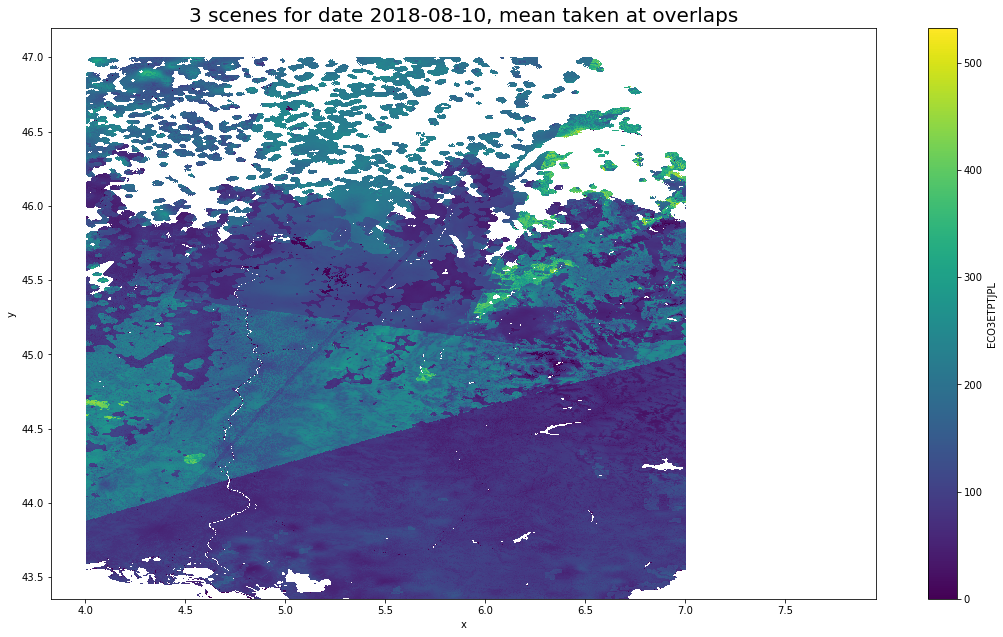

In [46]:
f,ax = plt.subplots(1)
date_to_plot = duplicate_dates[1]
et_vpd_ds["ECO3ETPTJPL"].sel(time=date_to_plot).plot.imshow(ax=ax)
f.set_size_inches(18.5, 10.5)
n_scenes = len(et_tseries_ds_dups.sel(time=date_to_plot)['time'])
plt.title(f"{n_scenes} scenes for date {date_to_plot}, mean taken at overlaps", fontsize=20)

Plotting ecostress availability

In [ ]:
et_tseries = et_tseries.sel(band=1)

In [ ]:
et_2018_may_sept=et_tseries.sel(date=slice("2018-06-01", "2018-09-30"))

et_2018_may_sept=et_2018_may_sept.chunk(chunks={"date": 101, "y": 1000, "x": 1000})

et_2018_may_sept = et_2018_may_sept.where(et_2018_may_sept > 0)

et_nonnan_count = ~np.isnan(et_2018_may_sept)

true_count = et_nonnan_count.astype(bool).sum(dim="date")

true_count_c = true_count.compute()

f, ax = plt.subplots(1)
true_count_c.plot.imshow(ax=ax)
plt.title("Number of ECOSTRESS Observations, May-Sept 2018")
france_river_lines.plot(ax=ax, color="red")
f.set_size_inches(18.5, 10.5)

Aggregating hourly data to dekad

In [ ]:
pev_dekad = met_dataset['pev'].resample(time='1D').sum().resample(time='10D').mean()

pev_dekad_2018 = pev_dekad.sel(time=slice("2018-01-01", "2018-10-01"))

met_dataset['pev'].sel(time="2019-04-01")

pev_dekad_2019.plot(x='longitude', y='latitude', col='time', col_wrap=5)

## pretty ET plotting

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
%matplotlib inline

ETcolors = ["#f6e8c3", "#d8b365", "#99974a", "#53792d", "#6bdfd2", "#1839c5"]
ETcmap = LinearSegmentedColormap.from_list("ET", ETcolors)
date_utc = pd.to_datetime(et['date'].values)
layer_type = et.attrs['filename'].split("_")[-3]
title = 'ECO3ETPTJPL Evapotranspiration'

fig = plt.figure(figsize=(9.7,7.6))                                                       # Set the figure size (x,y)
fig.suptitle(f'{title} ({layer_type}) \n at {date_utc}', fontsize=22)  # Add title for the plots
plt.axis('off')                                                                           # Remove axes from plot
im = plt.imshow(et.sel(band=1), cmap=ETcmap);                                                        # Plot array using colormap
# plt.scatter(Tcol, Trow, color="black", marker='x')                                        # Plot tower location
# Add a colormap legend
plt.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.004, label=f"ET ({et.attrs['units']})", shrink=0.6).outline.set_visible(True)

## Code graveyard

trying to plot xarray image data and geopandas data with ipyleaflet but it can't do image overlays yet (unless it comes from a server via url potentially)

In [ ]:
import ipyleaflet as ipyl
x = france_river_lines.unary_union.envelope.centroid.xy[0][0]
y = france_river_lines.unary_union.envelope.centroid.xy[1][0]
e, n, w, s =true_count_c.rio.bounds()
m = ipyl.Map(center = (y,x), zoom=6)

rivers_data = ipyl.GeoData(geo_dataframe = france_river_lines,
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Rivers')
m.add_layer(rivers_data)
plt.imsave("observation_count.jpeg",true_count_c)
obs_heatmap = ipyl.ImageOverlay(
    url="observation_count.jpeg",
    bounds=((s, w), (n, e))
)

m.add_layer(obs_heatmap)
m

trying to plot ecostress DataArray with geopandas shapes

In [ ]:
def cartopy_project_geo_df(df, crs):

    # This can be converted into a `proj4` string/dict compatible with GeoPandas
    crs_proj4 = crs.proj4_init
    return df.to_crs(crs_proj4)

crs = ccrs.PlateCarree()
aoi_projected = cartopy_project_geo_df(aoi, crs)
france_rivers_df_projected = cartopy_project_geo_df(france_rivers_df, crs)
# base = aoi_projected.plot(color="grey", edgecolor="black")
# france_rivers_df_projected.plot(ax=base, color="blue")


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
ax = plt.axes(projection=crs)
all_et_daily[14].sel(band=1).plot.imshow(ax=ax, transform=crs)
# ax.add_geometries(aoi_projected['geometry'], crs=crs)
ax.add_geometries(france_rivers_df_projected['geometry'], crs=crs)

In [ ]:
def mask_NA_values():
    """
    Daily ET products have both nan values from where there are clouds 
    and -1e+13 for where the ecostress swath was clipped during the ordering process
    """
    masked_et = np.ma.masked_where(et.sel(band=1) == np.nan, et.sel(band=1))
    masked_et = np.ma.masked_where(masked_et == -1e+13, masked_et)

In [ ]:
base = aoi.plot(color="grey", edgecolor="black")

france_rivers_df.plot(ax=base, color="blue")